# Final Project

### Authors: Kimia Abolhoda & Ariel Gutierrez

https://raw.githubusercontent.com/arielmata/CPSC392FinalData/main/ParisHousingClass.csv is imaginary data of house prices based in an urban environment - Paris.

## Data Information

- `squareMeters`: number of square meters this house has
- `numberOfRooms`: number of rooms this house has
- `hasYard`: 0 if the house does not have a yard, 1 if the house does have a yard
- `hasPool`: 0 if the house does not have a pool, 1 if the house does have a pool
- `floor`: number of floors the house has
- `cityCode`: the zip code the house is in
- `cityPartRange`: a metric that determines how exclusive the neighborhood of the house is, the higher the range, the more exclusive the neighborhood is
- `numPrevOwners`: the number of previous owners
- `made`: The year the house was built
- `isNewBuilt`: 0 if the house is not considered a new construction, 1 if the house is considered a new construction
- `hasStormProtector`: 0 if the house does not have a storm protector, 1 if the house does have a storm protector
- `basement`: number of square meters the basement has
- `attic`: number of square meters the attic has
- `garage`: number of square meters the garage has
- `hasStorageRoom`: number of storage rooms this house has
- `hasGuestRoom`: number of guest rooms this house has
- `price`: price of this house
- `category`: categorical variable; if luxury if the house is considered a luxury home; basic if the house is considered a basic home

## Questions
1. Is your classification model better at predicting Luxury or Basic houses?

2. Using your classification model, which of the continuous variables included in your model is the strongest predictor of a house being a Luxury home?

3. Is the relationship between squareMeters and numberOfRooms different for houses that do and do not have a pool?

4. Run a classification model using all the variables that predict the variable `category`. Then, run PCA on the predictors and build a model that uses a percentage cutoff and one that uses the elbow method. How much variance do these components cover? How does each model do on train/test accuracy? How does it compare to the full model?

5. Is there a relationship between the number of guest rooms (`hasGuestRooms`) and the year the house was built (`made`)? Does it differ for luxury homes and basic homes? How well did your model do based on predicting the price of the home using mean absolute error and $R^2$? Is your model overfit/underfit? How can you tell? Does your model do better for predicting the price for luxury houses than basic houses?

6.  Which clustering method would be best for this data and describe why do you think it is suited for the data using the variables `price`, `numberOfRooms`, and `made`. Make sure to include discussions of assumptions that each clustering method makes or does not make. Describe what characterizes each cluster.


In [1]:
# import necessary packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy as sp
from plotnine import *
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.model_selection import KFold


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, plot_confusion_matrix #model evaluation
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import train_test_split # simple TT split cv

import time

%precision %.7g
%matplotlib inline

In [2]:
# Import Data
paris = pd.read_csv("https://raw.githubusercontent.com/arielmata/CPSC392FinalData/main/ParisHousingClass.csv")
paris.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,category
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5,Basic
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5,Luxury
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1,Basic
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2,Basic
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0,Luxury


In [3]:
paris.isnull().sum() # check if there are any null values

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
category             0
dtype: int64

In [4]:
paris = pd.get_dummies(paris,columns=['category'],drop_first=True)

In [5]:
paris.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,category_Luxury
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5,0
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5,1
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1,0
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2,0
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0,1


In [6]:
predictors = ["squareMeters", "numberOfRooms", "hasYard", "hasPool", "floors",
              "cityCode", "cityPartRange", "numPrevOwners", "made", "isNewBuilt",
              "hasStormProtector", "basement", "attic", "garage", "hasStorageRoom",
              "hasGuestRoom", "price"]

cont_predictors = ["squareMeters", "numberOfRooms", "floors", "cityPartRange",
                  "numPrevOwners", "made", "basement", "attic", "garage", "hasGuestRoom",
                  "price"]

## Question 1

Is your classification model better at predicting Luxury or Basic houses?

In [7]:
X_train, X_test, y_train, y_test = train_test_split(paris[predictors], paris["category_Luxury"], test_size=0.1)

zscore = StandardScaler()
zscore.fit(X_train[cont_predictors])
Xz_train = zscore.transform(X_train[cont_predictors])
Xz_test = zscore.transform(X_test[cont_predictors])

In [8]:
myLogit = LogisticRegression(penalty = "none")

In [9]:
myLogit.fit(Xz_train, y_train)

LogisticRegression(penalty='none')

In [10]:
predictedVals = myLogit.predict(Xz_test)

In [11]:
accuracy_score(y_test, predictedVals)

0.894

In [12]:
mat1 = confusion_matrix(y_test, predictedVals)
print(mat1)

[[875  15]
 [ 91  19]]


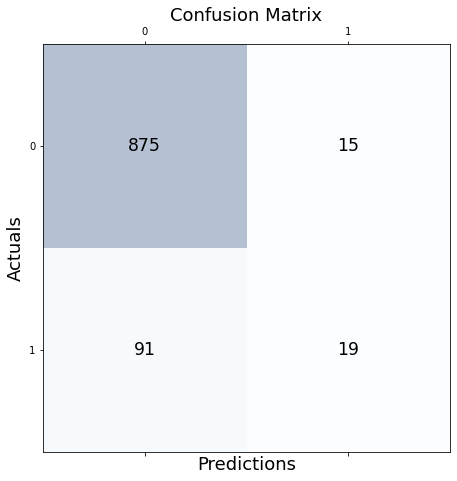

In [13]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(mat1, cmap=plt.cm.Blues, alpha=0.3)
for i in range(mat1.shape[0]):
    for j in range(mat1.shape[1]):
        ax.text(x=j, y=i,s=mat1[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [14]:
basic_acc = 827/(827+23)
basic_acc

0.9729412

In [15]:
lux_acc = 21/(21+129)
lux_acc

0.14

In [16]:
acc_df = {"Home Type":["Basic", "Luxury"],
         "Accuracy": [basic_acc, lux_acc]}
acc_df = pd.DataFrame(acc_df)
acc_df

,Home Type,Accuracy
0,Basic,0.972941
1,Luxury,0.140000


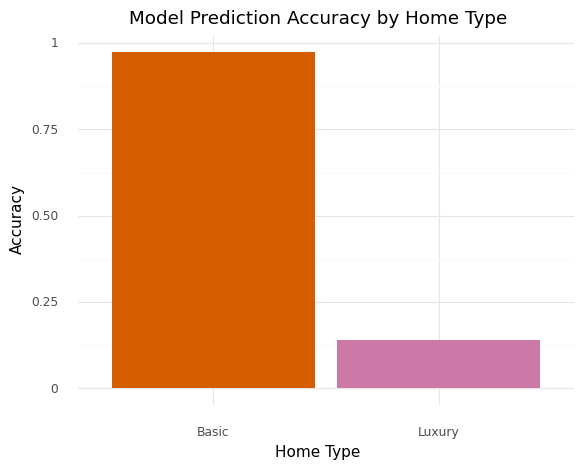

<ggplot: (324284919)>

In [17]:
(ggplot(acc_df, aes(x = "Home Type", y = "Accuracy", fill = "Home Type")) + 
 geom_bar(stat = "identity") + theme_minimal() + 
 ggtitle("Model Prediction Accuracy by Home Type") +
 scale_fill_manual(["#d55e00", "#cc79a7", "#0072b2", "#f0e442", "#009e73"]) +
 labs(x = "Home Type", y = "Accuracy") +
 theme(legend_position = "none"))

In [18]:
basic_prec = 827/(129+827)
basic_prec

0.8650628

In [19]:
lux_prec = 21/(21+23)
lux_prec

0.4772727

In [20]:
prec_df = {"Home Type":["Basic", "Luxury"],
         "Precision": [basic_prec, lux_prec]}
prec_df = pd.DataFrame(prec_df)
prec_df

,Home Type,Precision
0,Basic,0.865063
1,Luxury,0.477273


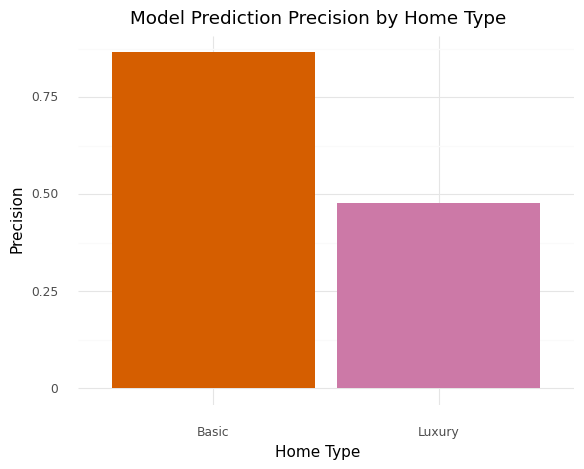

<ggplot: (324422394)>

In [21]:
(ggplot(prec_df, aes(x = "Home Type", y = "Precision", fill = "Home Type")) + 
 geom_bar(stat = "identity") + theme_minimal() + 
 ggtitle("Model Prediction Precision by Home Type") +
 scale_fill_manual(["#d55e00", "#cc79a7", "#0072b2", "#f0e442", "#009e73"]) +
 labs(x = "Home Type", y = "Precision") +
 theme(legend_position = "none"))

- To answer this question we looked at the confusion matrix of our Logistic Regression model which included all of our variables and had a train-test-split of 90/10. The confusion matrix is a performance measurement that tells us how much of our data we predicted correctly and how much we predicted incorrectly. Luxury homes are denoted by 1 and Basic homes are denoted by 0. Here, we can see that our model predicted that a home was a basic home when it actually was a basic home 875 times and predicted that a home was a luxury home when it actually was a luxury home only 19 times. For our luxury data, we had 91 false predictions and only 15 false predictions for our basic homes.

- From the information in our confusion matrix we were able to pull accuracy insights for our model based on home type. Accuracy is the ratio of correctly predicted data by the total data. So of the total basic data that our model ran, we had an accurate prediction about 97% of the time. And for our luxury data we had accurate predictions only 14% of the time. We can see this visualization in our graph for accuracy by home type. The home classifications had nearly opposite accuracy metrics. Therefore, we can say that our model is much more accurate with predicting basic homes.

- We can also look at how our model did on precision for each home type. Precision is the ratio of correct positive predictions to the total predicted positives. So of the number of times our model predicted that a home was basic, it was correct about 86% of the time. And of the times our model predicted a home was luxury, it was correct about 48% of the time. So when our model predicts that a house is basic, it will be correct nearly twice as often as when our model predicts that a house is luxury. Compared to the last metric we can see that luxury prediction does better with precision, however our model is still much more precise with basic homes.

- Overall, we can see that our model is better at predicting that a house is a basic house. This could be due to the fact that our data naturally has a larger amount of basic home data points compared to luxury homes as we can see in our confusion matrix and so our model is better trained for basic homes and cannot perform or learn as well on luxury homes. Our answer is important because if we were to use this model to assess the value of a home, we would want to know how reliable it is in determining if the house is a luxury or basic home which would probably have an effect on how much the home is worth. We now know that if we were interested in purchasing a luxury home, this model would not be the most effective in finding us one.

## Question 2

Which of the following continuous variables (number of floors, city code, city part range, number of previous owners, year made) included in your model has the strongest impact on the likelihood of a house being a Luxury home?

In [22]:
coef = pd.DataFrame({"Coef": myLogit.coef_[0],
              "Name": cont_predictors})
coef["Odds Coef"] = np.exp(coef["Coef"])
coef

,Coef,Name,Odds Coef
0,-1450.671193,squareMeters,0.000000
1,-0.013071,numberOfRooms,0.987014
2,-0.944387,floors,0.388918
3,-0.092989,cityPartRange,0.911204
4,-0.048797,numPrevOwners,0.952375
5,0.021100,made,1.021325
6,-0.038652,basement,0.962085
7,-0.000282,attic,0.999718
8,-0.011819,garage,0.988250
9,0.051816,hasGuestRoom,1.053182


In [23]:
strong = coef.iloc[2:7]
strong

,Coef,Name,Odds Coef
2,-0.944387,floors,0.388918
3,-0.092989,cityPartRange,0.911204
4,-0.048797,numPrevOwners,0.952375
5,0.021100,made,1.021325
6,-0.038652,basement,0.962085


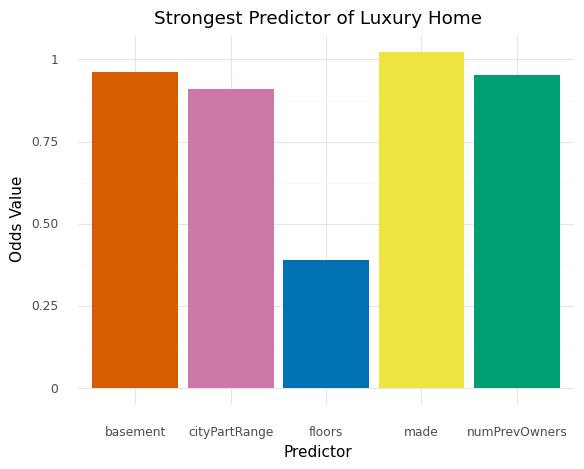

<ggplot: (324453373)>

In [24]:
(ggplot(strong, aes(x = "Name", y = "Odds Coef", fill = "Name")) + 
 geom_bar(stat = "identity") + theme_minimal() + 
 ggtitle("Strongest Predictor of Luxury Home") +
 scale_fill_manual(["#d55e00", "#cc79a7", "#0072b2", "#f0e442", "#009e73"]) +
 labs(x = "Predictor", y = "Odds Value") +
 theme(legend_position = "none"))

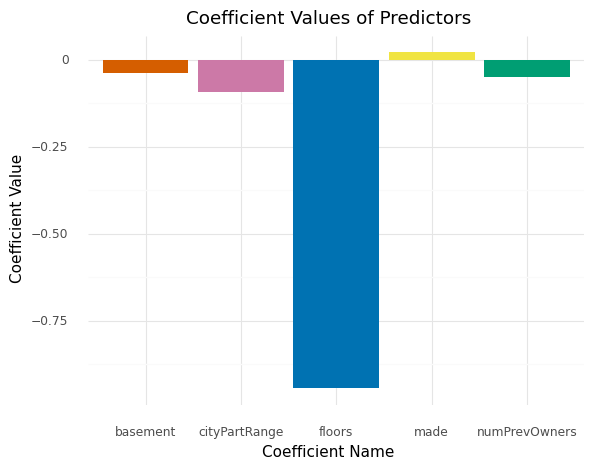

<ggplot: (324476907)>

In [25]:
(ggplot(strong, aes(x = "Name", y = "Coef", fill = "Name")) + 
 geom_bar(stat = "identity") + theme_minimal() + 
 ggtitle("Coefficient Values of Predictors") +
 scale_fill_manual(["#d55e00", "#cc79a7", "#0072b2", "#f0e442", "#009e73"]) +
 labs(x = "Coefficient Name", y = "Coefficient Value") +
 theme(legend_position = "none"))

- Using our same model from Question 1, we are looking at the impact of these continuous variables on the likelihood of a house being considered luxury. In the above graph we are comparing the odds ratios of the predictors. The odds ratio is a measure of association that represents the odds from 0 to infinity that an outcome will occur given a particular event, compared to the odds of 1 that the outcome occurring in the absence of that event. Here we can see that the predictor with the odds ratio value that is further from 1 is floors. Floors has an odds ratio of about 0.39 which means that as floors increases by 1 standard deviation, the odds or likelihood that that house is luxury is multiplied by 0.39. The house becomes 0.39 times less likely to be classified as luxury.

- We are also looking at the coefficients of the predictors. And we can see that, again, floors has the greatest impact on whether a house is luxury or not. Our coefficients are expressed in terms of log odds, so here we can say that as floors increases by one standard deviation, the log odds of a house being luxury decreases by 0.94. A negative log odd indicates a decrease in likelihood. As we can see in our dataframe and coefficient graph, floors has the greatest absolute value for log odds, therefore, it has the greatest impact on the probability if a house is luxury and decreases the probability. 

- From this evaluation, it is obvious that of this selection of continuous variables, floors has the greatest impact on the likelihood of a house being predicted to be a Luxury home. This answer is important because it gives us insight into the what attributes of a house impact its qualifications to be considered luxury. We can understand what is desirable for luxury homes, especially if we are in the business of designing luxury homes, we want to have a good understanding of what contributes to the house's status.

## Question 3

Do houses made after the year 2000 (new houses) with less than 6 floors have a higher average probability of being a Luxury home than houses made before the year 2000 (old houses) with a pool?

In [26]:
condition1 = sum((paris.made > 2000) &
                 (paris.floors > 6) &
                 (paris.category_Luxury == 1))

prob1 = condition1/sum((paris.category_Luxury == 1))

prob1

0.6071146

In [27]:
condition2 = sum((paris.made < 2000) & 
                 (paris.hasPool == 1) &
                 (paris.category_Luxury == 1))

prob2 = condition2/sum((paris.category_Luxury == 1))

prob2

0.3225296

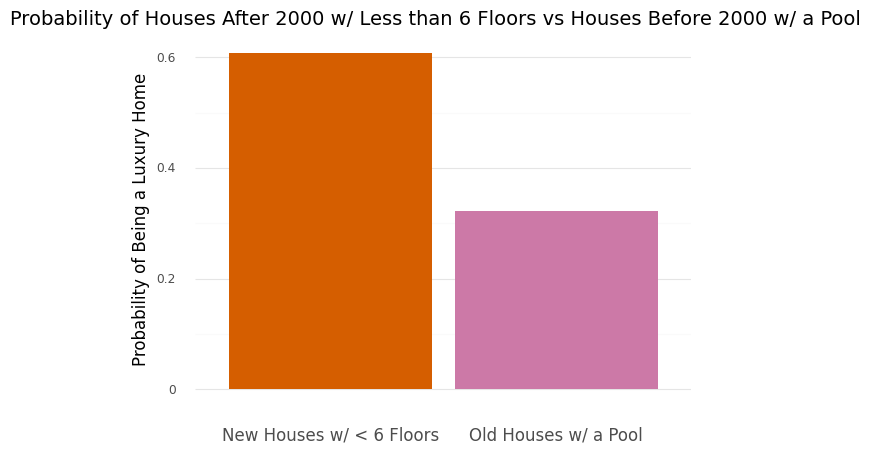

<ggplot: (324453488)>

In [28]:
houses2000 = pd.DataFrame({"Names": ["New Houses w/ < 6 Floors","Old Houses w/ a Pool"], 
                           "Prob": [prob1,prob2]})

(ggplot(houses2000, aes(x = "Names", y = "Prob", fill = "Names")) +
geom_bar(stat = "identity") + theme_minimal() +
labs(title = "Probability of Houses After 2000 w/ Less than 6 Floors vs Houses Before 2000 w/ a Pool",
x = "", y = "Probability of Being a Luxury Home") + 
 theme(axis_title_y = element_text(size = 12), 
       axis_text_x = element_text(size = 12), 
       plot_title = element_text(size = 14), 
       panel_grid_major_x = element_blank(), 
       legend_position = "none") + scale_fill_manual(["#d55e00", "#cc79a7"]))

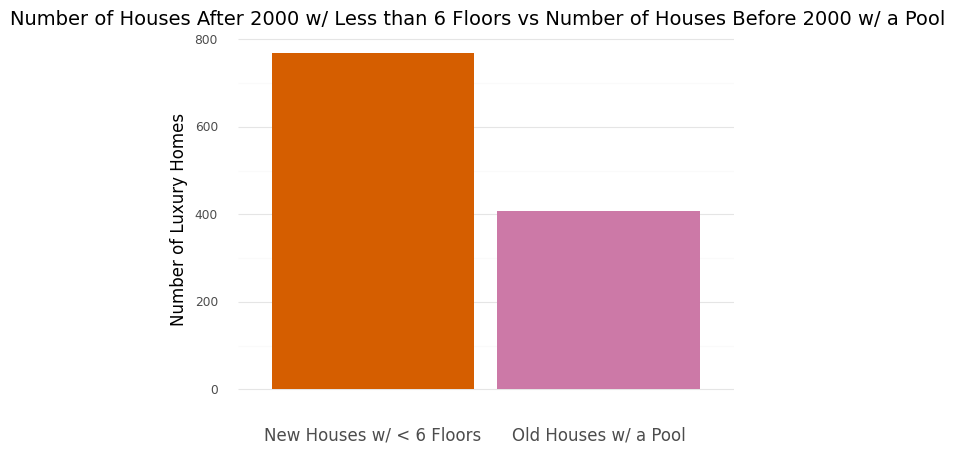

<ggplot: (324325747)>

In [29]:
numhouses2000 = pd.DataFrame({"Names": ["New Houses w/ < 6 Floors","Old Houses w/ a Pool"], 
                           "Prob": [condition1,condition2]})

(ggplot(numhouses2000, aes(x = "Names", y = "Prob", fill = "Names")) +
geom_bar(stat = "identity") + theme_minimal() +
labs(title = "Number of Houses After 2000 w/ Less than 6 Floors vs Number of Houses Before 2000 w/ a Pool",
x = "", y = "Number of Luxury Homes") + 
 theme(axis_title_y = element_text(size = 12), 
       axis_text_x = element_text(size = 12), 
       plot_title = element_text(size = 14), 
       panel_grid_major_x = element_blank(), 
       legend_position = "none") + scale_fill_manual(["#d55e00", "#cc79a7"]))

- Our original question 3 from our initial analysis plan was substituted for this question because we found that due to the fact that our dataset is imaginary, much of the data seemed to be quite random so many of our variables had no relationship at all and very little correlation. So, the relationships of the variables were difficult to capture and provided little to no insight for our data. Therefore, we decided to analyze this question instead.

- To analyze this question, we calculated the probability of the conditions we were evaluating for Luxury homes. We did this by totaling the number of houses that met our criteria, so the number of luxury houses built after the year 2000 with less than 6 floors and the number of luxury homes built before 2000 with a pool. We took these totals and divided it by the total number of luxury homes to see how common each set of events is within our total population of homes. From there, we were able to analyze the probability.

- The second bar graph represents a visualization of how many of our total luxury homes have the features we are looking at. So we can see that out of all of our luxury homes, 768 are built after the year 2000 that also have less that 6 floors. And out of all of our luxury homes, only 408 of them were built before the year 2000 AND have a pool. So we can see that a home that is built after 2000 with less than 6 floors is nearly twice as likely of being a luxury home than a house built before 2000 with a pool.

- Our first bar graph shows a visualization in terms of probability that essentially says the same thing. This takes our total number of each scenario and divides it by the total number of luxury homes to get probability. It is 61% probable that a home built after 2000 with less than 6 floors is a luxury home and only 32% probable for a home built before 2000 WITH a pool. A home that is built after 2000 with less than 6 floors is twice as likely to be luxury. From our last question we saw that number of floors has a negative on the probability of a house being considered luxury so this could have attributed to the 61% likelihood. We can kind of see that despite a house having an ammenity like a pool, that does have as much positive effect on a home being luxury as the year it was made and number of floors it has. So, perhaps luxury homes started becoming more popular later. This answer gives us a little bit more insight into the qualifications of a luxury home and the preferences home owners have for luxury homes. We can again see that homes with less floors are more likely to be considered luxury and luxury homes with pools are not as common.

## Question 4

Run a classification model using all the variables that predict the variable `category`. Then, run PCA on the predictors and build a model that uses a percentage cutoff and one that uses the elbow method. How much variance do these components cover? How does each model do on train/test accuracy? How does it compare to the full model?

In [31]:
# Split Data
# TTS: 90-10 percent split
X_train, X_test, y_train, y_test = train_test_split(paris[cont_predictors], paris["category_Luxury"], test_size=0.1)

# standardizing all numeric variables
z1 = StandardScaler()
X_train = z1.fit_transform(X_train)
X_test = z1.transform(X_test)

# PCA model
pca = PCA() # from sklearn
pca.fit(X_train)

# dataframe that stores the explained variance for each PC and the cummulative variance
# we will use this data frame to create our scree plot
pcaDF = pd.DataFrame({"expl_var" : pca.explained_variance_ratio_, "pc": range(1,12), 
                      "cum_var": pca.explained_variance_ratio_.cumsum()})
pcaDF.head(17)

,expl_var,pc,cum_var
0,1.819803e-01,1,0.181980
1,9.727427e-02,2,0.279255
2,9.381238e-02,3,0.373067
3,9.258414e-02,4,0.465651
4,9.092130e-02,5,0.556572
5,9.072142e-02,6,0.647294
6,8.950588e-02,7,0.736800
7,8.855202e-02,8,0.825352
8,8.774086e-02,9,0.913093
9,8.690740e-02,10,1.000000


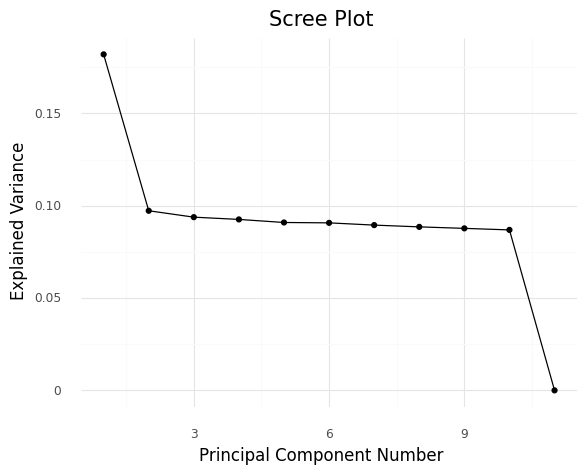

<ggplot: (324563122)>

In [32]:
(ggplot(pcaDF, aes(x = "pc", y = "expl_var")) + geom_line() + geom_point()
 + theme_minimal() + 
 ggtitle("Scree Plot") +
 labs(x = "Principal Component Number", y = "Explained Variance") +
 theme(axis_title_y = element_text(size = 12),
     axis_title_x = element_text(size = 12),
     plot_title = element_text(size = 15)))

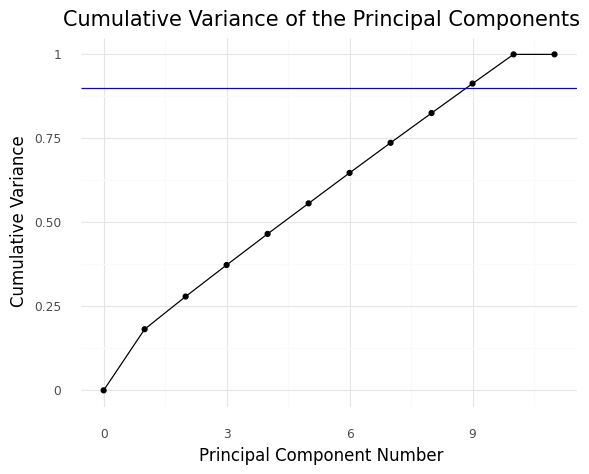

<ggplot: (326698174)>

In [33]:
# mirrors our other graph but instead has cum_var instead of explained var.
pcaDF = pcaDF.append({"expl_var": 0, "pc": 0, "cum_var": 0}, ignore_index = True)

(ggplot(pcaDF, aes(x = "pc", y = "cum_var")) + geom_line() +
 geom_point() + geom_hline(yintercept = 0.90, color = "blue") +
 ggtitle("Cumulative Variance of the Principal Components") +
 labs(x = "Principal Component Number", y = "Cumulative Variance") +
 theme_minimal() +
 theme(axis_title_y = element_text(size = 12),
     axis_title_x = element_text(size = 12),
     plot_title = element_text(size = 15)))

In [34]:
# PCA
pcomps9 = pca.transform(X_train)
pcomps9 = pd.DataFrame(pcomps9[:,0:9]) # we only want the first 9 components (explain 90% of data)
pcomps9_test = pca.transform(X_test)
pcomps9_test = pd.DataFrame(pcomps9_test[:,0:9])

pcomps2 = pca.transform(X_train)
pcomps2 = pd.DataFrame(pcomps2[:,0:2]) # we only want the first 2 components elbow method)
pcomps2_test = pca.transform(X_test)
pcomps2_test = pd.DataFrame(pcomps2_test[:,0:2])

# using all original variables
lr = LogisticRegression()
lr.fit(X_train, y_train)

# logistic regression - Percentage retained variance method
lr2 = LogisticRegression()
lr2.fit(pcomps9, y_train)

# logistic regression - Elbow/inflection method
lr3 = LogisticRegression()
lr3.fit(pcomps2, y_train)

#record the accuracy for both training/test sets of the logistic regression using all original variables
print("All Data Train Accuracy: " + str(accuracy_score(y_train, lr.predict(X_train))))
print("All Data Test Accuracy:  " + str(accuracy_score(y_test, lr.predict(X_test))))
print()

#record the accuracy for both training/test sets of the logistic regression using 9 PCs (percentage retained)
print("9 PC Train Accuracy:   ", accuracy_score(y_train, lr2.predict(pcomps9)))
print("9 PC Test Accuracy:    ", accuracy_score(y_test, lr2.predict(pcomps9_test)))
print()

#record the accuracy for both training/test sets of the logistic regression using 2 PCs (elbow method)
print("2 PC Train Accuracy:   ", accuracy_score(y_train, lr3.predict(pcomps2)))
print("2 PC Test Accuracy:    ", accuracy_score(y_test, lr3.predict(pcomps2_test)))

All Data Train Accuracy: 0.8726666666666667
All Data Test Accuracy:  0.881

9 PC Train Accuracy:    0.8726666666666667
9 PC Test Accuracy:     0.881

2 PC Train Accuracy:    0.8726666666666667
2 PC Test Accuracy:     0.881


In [35]:
# correlations of the continuous variables in the data set
paris[cont_predictors].corr()

,squareMeters,numberOfRooms,floors,cityPartRange,numPrevOwners,made,basement,attic,garage,hasGuestRoom,price
squareMeters,1.000000,0.009573,0.001109,0.008758,0.016619,-0.007207,-0.003960,-0.000588,-0.017246,-0.000623,0.999999
numberOfRooms,0.009573,1.000000,0.022244,0.008340,0.016766,0.003978,-0.013990,0.012061,0.023188,-0.015529,0.009591
floors,0.001109,0.022244,1.000000,-0.004921,0.002463,0.005022,0.006228,-0.000270,0.011303,-0.021155,0.001654
cityPartRange,0.008758,0.008340,-0.004921,1.000000,0.009238,0.007748,0.004743,0.010696,-0.001648,-0.007153,0.008813
numPrevOwners,0.016619,0.016766,0.002463,0.009238,1.000000,0.006858,-0.000862,0.000719,0.020268,-0.006082,0.016619
made,-0.007207,0.003978,0.005022,0.007748,0.006858,1.000000,-0.005506,0.013773,0.005687,-0.005431,-0.007210
basement,-0.003960,-0.013990,0.006228,0.004743,-0.000862,-0.005506,1.000000,-0.003180,0.000117,-0.020732,-0.003967
attic,-0.000588,0.012061,-0.000270,0.010696,0.000719,0.013773,-0.003180,1.000000,-0.000611,-0.011995,-0.000600
garage,-0.017246,0.023188,0.011303,-0.001648,0.020268,0.005687,0.000117,-0.000611,1.000000,-0.017316,-0.017229
hasGuestRoom,-0.000623,-0.015529,-0.021155,-0.007153,-0.006082,-0.005431,-0.020732,-0.011995,-0.017316,1.000000,-0.000644


- For this question, we decided to make a new logistic regression model that uses only continuous variables to compare to the logistic regression models using principal component analysis. Principal Component Analysis (PCA) works by taking advantage of the relationships and shared information between the variables and creates these new principal components that explain much more of the data in fewer variables. PCA finds a more efficient set of axes to explain the variation in the data through the use of eigenvectors and eigenvalues.

- Moreover, we used a train test split of 90% to 10% for model validation, which we will use for all three models. We also z-scored all the variables, since they are continuous and we want to set them on the same scale.

- From the cumulative variances graph, we can tell that the relationships between the raw variables is pretty weak because the line of the graph is almost a diagonal line when using the middle principal components in the graph. This means that there is barely any information shared with the raw variables. Moreover, the correlations are low for almost all the variables. The only two variables that are highly correlated are squareMeters and price, as shown as having 0.999999 correlation in the table above. Other than that each principal component contributes about an equal amount of the variance. When variables are unrelated, it looks like PCA does not have too much benefit since it is hard to get rid of a lot of the variables. 

- The first method we used to choose how many principal components we should use is the percent retained variance method. We wanted to cover at least 90% of the variance of the original data. If we look at the cumulative varaince graph above, the blue line represents the 90% cutoff so we used 9 principal components, which covers around 91.405% of the variance. It is important to note that because the raw variables do not share much information with eachother we are not really benefitting from PCA, since we are left with 9 principal components. This is not much of a difference considering that our first logistic regression model using all the continuous variables uses 11 raw variables.

- The second method we used to choose how many principal components we should use is the elbow/inflection method. We select the number of components we want to use by finding the "elbow" of the scree plot, this is the inflection point. By looking at the scree plot above, we notice that it has weird shape to it with 2 inflection points. We decided to use the first inflection point which is at 2 principal components. The 2 principal components cover around 27.9092% of the variance.

- With all three models, we obtained a train accuracy of around 0.87267 and a test accuracy of 0.881. I think this is because squareMeters and price are strongly related; thisexplains the weird shape in our scree plot.

- Overall, PCA is very effective if a lot of our variables share a lot of the same information because of the dimensionality reduction. However, in our case we did not see that much information shared between the variables, which is why we could not retain 90% of the variance with a small number of principal components.

## Question 5
Is there a relationship between the number of guest rooms (`hasGuestRooms`) and the year the house was built (`made`)? Does it differ for luxury homes and basic homes? How well did your model do based on predicting the price of the home using mean absolute error and $R^2$? Is your model overfit/underfit? How can you tell? Does your model do better for predicting the price for luxury houses than basic houses?

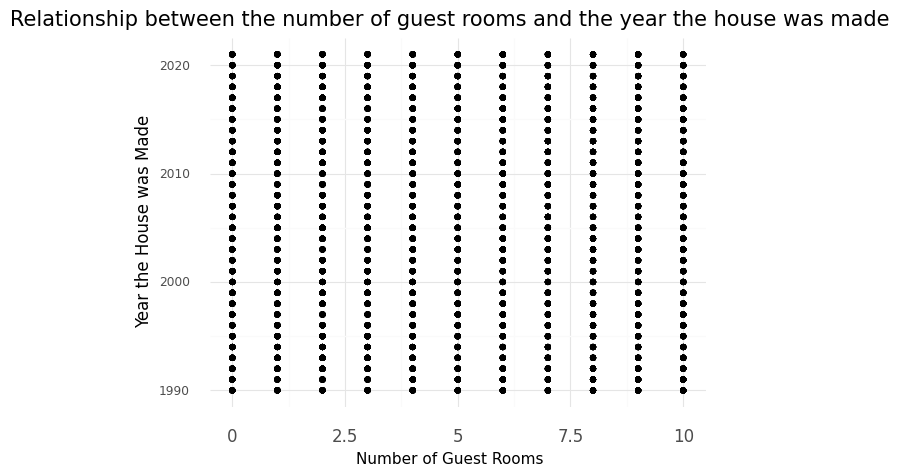

<ggplot: (324411185)>

In [36]:
# scatterplot of hasGuestRoom and made
(ggplot(paris, aes(x = "hasGuestRoom", y = "made")) +
 geom_point() + theme_minimal() +
 labs(title = "Relationship between the number of guest rooms and the year the house was made",
     x = "Number of Guest Rooms", y = "Year the House was Made") +
 theme(axis_title_y = element_text(size = 12),
       axis_text_x = element_text(size = 12),
       plot_title = element_text(size = 15)))

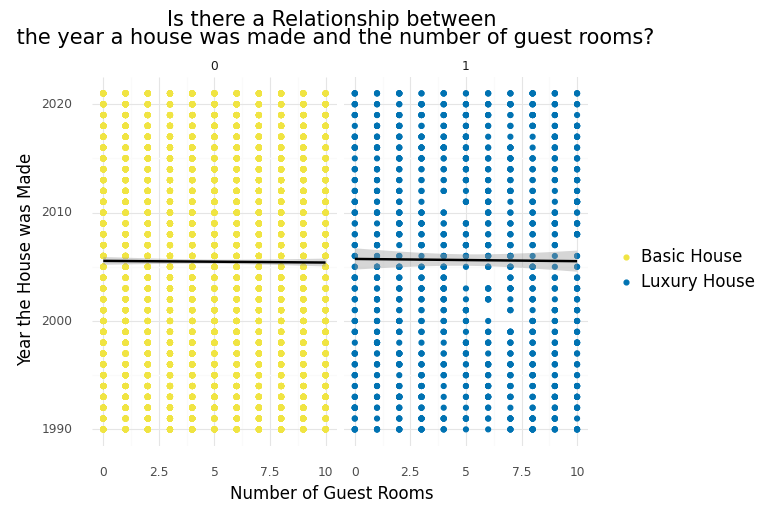

<ggplot: (326732563)>

In [37]:
# scatterplot of hasGuestRoom and made between luxury and basic houses
(ggplot(paris, aes(x = "hasGuestRoom", y = "made", color = "factor(category_Luxury)")) + 
 theme_minimal() + geom_point() + facet_wrap("~category_Luxury") +
 labs(title = "Is there a Relationship between\n the year a house was made and the number of guest rooms?",
     x = "Number of Guest Rooms",
     y = "Year the House was Made",
     color = "") +
 geom_smooth(method = "lm", color = "black") +
 theme(axis_title_y = element_text(size = 12),
     axis_title_x = element_text(size = 12),
     plot_title = element_text(size = 15),
     legend_text = element_text(size = 12)) + 
 scale_color_manual(labels = ["Basic House",
                              "Luxury House"],
                    values = ["#f0e442", "#0072b2"]))

In [38]:
# Split Data
# TTS: 90-10 percent split
predictors = ['squareMeters','numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom']
X_train, X_test, y_train, y_test = train_test_split(paris[predictors], paris["price"], test_size=0.1)

# standardizing all numeric variables
z1 = StandardScaler()
X_train[predictors] = z1.fit_transform(X_train[predictors])
X_test[predictors] = z1.transform(X_test[predictors])

# Build Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

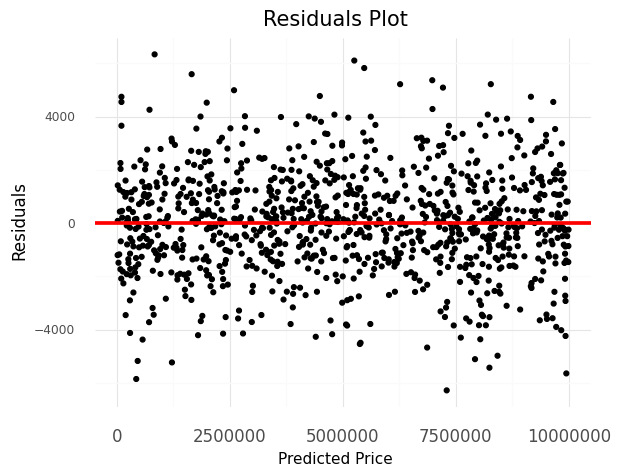

<ggplot: (326920479)>

In [39]:
# make residual plot
y_pred = lr.predict(X_test) # test data

assump = pd.DataFrame({"error": y_test - y_pred, "pred": y_pred})

(ggplot(assump, aes(x = "pred", y = "error")) + geom_point() + 
     labs(x = "Predicted Price", y = "Residuals",
          title = "Residuals Plot") + 
     theme_minimal() + geom_hline(yintercept = 0, color = "red", size = 1.5) +
     theme(axis_text_x = element_text(size = 12),
     axis_title_y = element_text(size = 12),
     plot_title = element_text(size = 15)))

In [40]:
print("Training Set Mean Absolute Error: ",  mean_absolute_error(y_train, lr.predict(X_train)))
print("Testing Set Mean Absolute Error:  ",  mean_absolute_error(y_test, lr.predict(X_test)))
print()
print("Training Set R2:", r2_score(y_train, lr.predict(X_train)))
print("Testing Set R2:", r2_score(y_test, lr.predict(X_test)))

Training Set Mean Absolute Error:  1478.4099731551514
Testing Set Mean Absolute Error:   1473.720162306013

Training Set R2: 0.9999995630653138
Testing Set R2: 0.9999995844006013


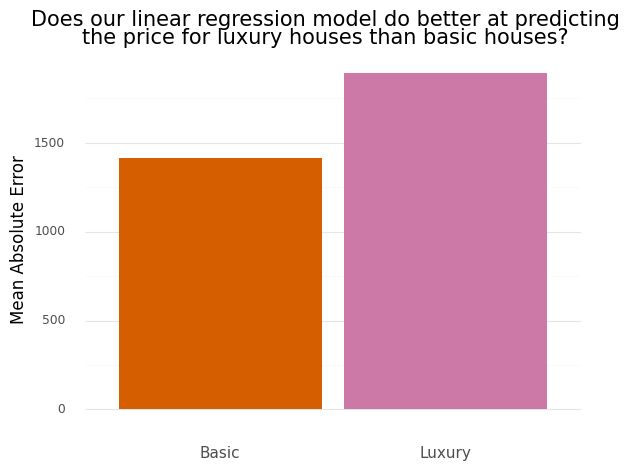

<ggplot: (327021996)>

In [41]:
# define the luxury and basic homes categories
luxury = paris["category_Luxury"] == 1
basic = paris["category_Luxury"] == 0
MAE = [] 

# for loop predicts and computes accuracy using LR model for each category
for category in [luxury, basic]:
    Ypred = lr.predict(X_test.loc[category])
    MAE.append(mean_absolute_error(y_test.loc[category], Ypred))

# accuracies are stored in a data frame to then make our bar chart
d_inc = pd.DataFrame({"Names": ["Luxury", "Basic"], "MAE": MAE})

(ggplot(d_inc, aes(x = "Names", y = "MAE", fill = "Names")) +
 geom_bar(stat = "identity") + theme_minimal() +
 labs(title = "Does our linear regression model do better at predicting\nthe price for luxury houses than basic houses?",
     x = "", y = "Mean Absolute Error") +
 theme(axis_title_y = element_text(size = 12),
     axis_text_x = element_text(size = 11),
     plot_title = element_text(size = 15),
     legend_position = "none",
     panel_grid_major_x = element_blank(),) +
 scale_fill_manual(["#d55e00", "#cc79a7", "#0072b2",
                     "#f0e442", "#009e73",'#004D40']))

- The scatterplot representing the relationship between the year a house was built and the number of guest rooms has no non-linear patterns in the data. For example, a clear non-linear pattern would be a shape of a parabola or a trigonometric wave. The variables are uncorrelated, which is seen in the almost random looking pattern in the data. Even if we attempt to compare the subsets of a basic house and a luxury house, the data looks random.

- For this question, we used a linear regression model because it is a predictive model for continuous variables, such as the price of a home. When doing a Linear Regression model it is important to remember that it carries the assumption that the relationship between the variables are linear and that homoscedasticity holds, which means that the variation of errors is the same. In our scatterplot representing the relationship between the year a house was built and the number of guest rooms we see that there is no clear non-linear patterns in the data so we will go on with the Linear Regression. To check if homoscedasticity holds, we want to see if the variation of errors is the same than in others. If there is more error in some areas than others, then that means that our model is better at predicting at some places than others. In our residuals plot, we found that there seems to be a pattern portraying a downwards slope. For lower prices, the model seems to underpredict for lower prices and overpredict for higher prices. But note that our model is working with prices so even if the residuals look large, a 6000 residual is not that big when considering the prices of houses. Thus, our model holds for homoscedasticity.

- After completing the linear regression, we obtained an mean absolute value score for both the training and testing set of 1478.4 and 1473.7, respectively. Mean absolute error tells us how close a linear regression line is to a set of points by taking the distances from the points to the linear regression line and finding the average. The lower the mean absolute error score means then the better the prediction. If we look back at the values we obtained, which may seem large, we need to consider that they are in the units of price. Considering that we are making predictions for the price of a house, then this is actually a small mean absolute error score. Therefore, our model is performing well with small errors.

- Moreover, our $R^2$ score for both the training and testing set are around 0.99999.  $R^2$ is a measurement of the spread between the numbers in the data set, and an $R^2$ of 1 means that the linear regression's predictions perfectly fit the data. This means that our model is performing extremely well.

- Because the model is performing extremely well for both the training data and the testing data, then the model is not overfit or underfit. Recall that a model is overfit if it does really well for the training data but performs poorly for the testing data. A model is underfit if it does poorly for both the traininig and testing sets.

- By looking at the bar chart above, we see that our model has a lower mean absolute error when predicting the prices of basic houses than luxury houses, so that indicates that the model performs better at predicting the prices of basic houses. Though I think it is important to note that the difference between mean absolute errors is pretty small since we are considering prices of houses.

## Question 6

Which clustering method would be best for this data and describe why do you think it is suited for the data using the variables `price`, `numberOfRooms`, and `made`. Make sure to include discussions of assumptions that each clustering method makes or does not make. Describe what characterizes each cluster.

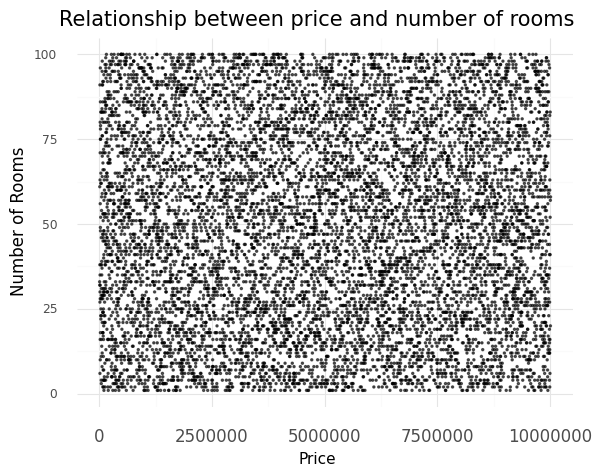

<ggplot: (327047431)>

In [42]:
# price vs numberOfRooms scatterplot
(ggplot(paris, aes(x = "price", y = "numberOfRooms")) +
 geom_point(size = 0.4, alpha = 0.6) + theme_minimal() +
 labs(title = "Relationship between price and number of rooms",
     x = "Price", y = "Number of Rooms") +
 theme(axis_title_y = element_text(size = 12),
       axis_text_x = element_text(size = 12),
       plot_title = element_text(size = 15)))

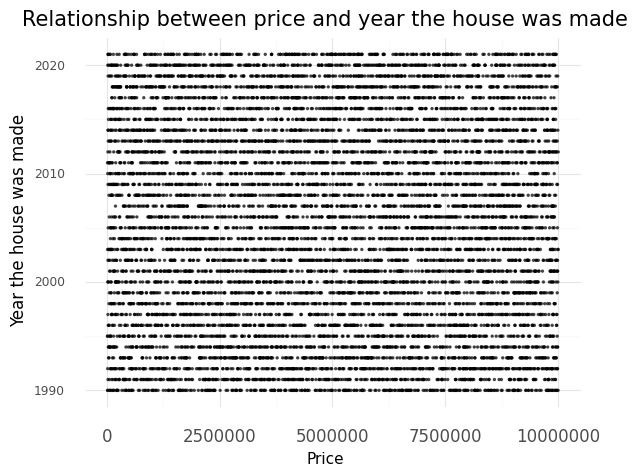

<ggplot: (327072338)>

In [43]:
# price vs made scatterplot
(ggplot(paris, aes(x = "price", y = "made")) +
 geom_point(size = 0.4, alpha = 0.6) + theme_minimal() +
 labs(title = "Relationship between price and year the house was made",
     x = "Price", y = "Year the house was made") +
 theme(axis_title_y = element_text(size = 12),
       axis_text_x = element_text(size = 12),
       plot_title = element_text(size = 15)))

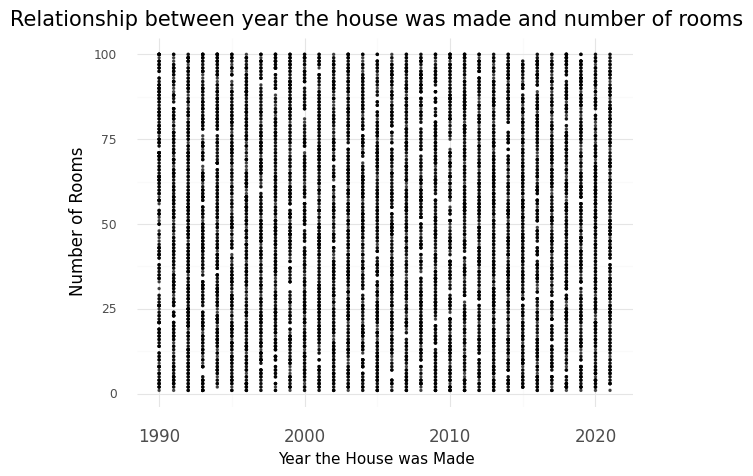

<ggplot: (327237687)>

In [44]:
# made vs numberOfRooms scatterplot
(ggplot(paris, aes(x = "made", y = "numberOfRooms")) +
 geom_point(size = 0.4, alpha = 0.6) + theme_minimal() +
 labs(title = "Relationship between year the house was made and number of rooms",
     x = "Year the House was Made", y = "Number of Rooms") +
 theme(axis_title_y = element_text(size = 12),
       axis_text_x = element_text(size = 12),
       plot_title = element_text(size = 15)))

In [45]:
features = ['price','made','numberOfRooms']
start_time = time.time()
X = paris[features]

hac = AgglomerativeClustering(affinity = "euclidean",
                             linkage = "ward")
hac.fit(X)

AgglomerativeClustering()

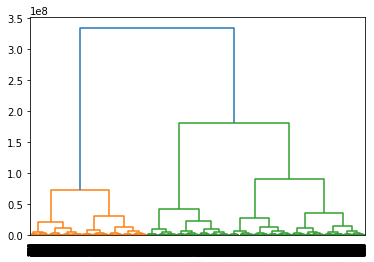

In [46]:
dendro = sch.dendrogram(sch.linkage(X, method='ward'))

In [47]:
print("Time for HAC and dendrogram: %s seconds" % (time.time() - start_time))

Time for HAC and dendrogram: 280.988746881485 seconds


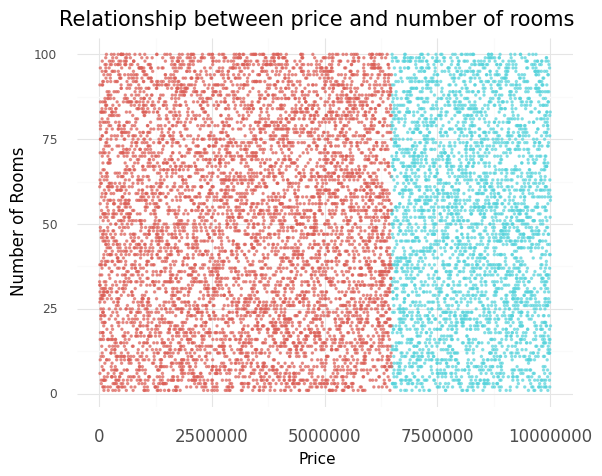

<ggplot: (331889655)>

In [48]:
membership = hac.labels_
paris["cluster2"] = membership

# price vs numberOfRooms scatterplot with cluster coloring
(ggplot(paris, aes(x = "price", y = "numberOfRooms", color = "factor(cluster2)")) +
 geom_point(size = 0.4, alpha = 0.6) + theme_minimal() +
 labs(title = "Relationship between price and number of rooms",
     x = "Price", y = "Number of Rooms") +
 theme(axis_title_y = element_text(size = 12),
       axis_text_x = element_text(size = 12),
       plot_title = element_text(size = 15),
       legend_position = "none"))

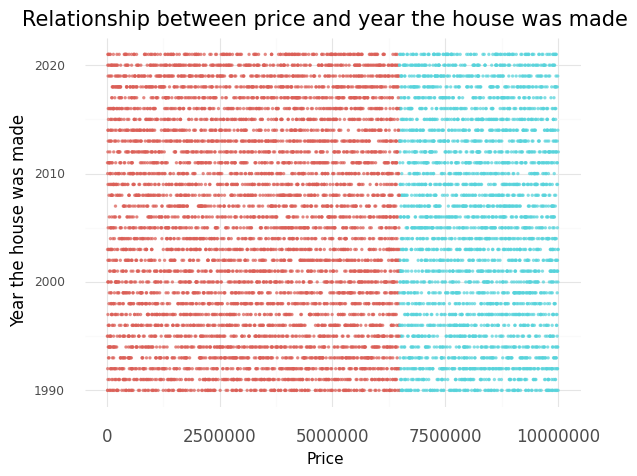

<ggplot: (332261175)>

In [49]:
# price vs made scatterplot with cluster coloring
(ggplot(paris, aes(x = "price", y = "made", color = "factor(cluster2)")) +
 geom_point(size = 0.4, alpha = 0.6) + theme_minimal() +
 labs(title = "Relationship between price and year the house was made",
     x = "Price", y = "Year the house was made") +
 theme(axis_title_y = element_text(size = 12),
       axis_text_x = element_text(size = 12),
       plot_title = element_text(size = 15),
       legend_position = "none"))

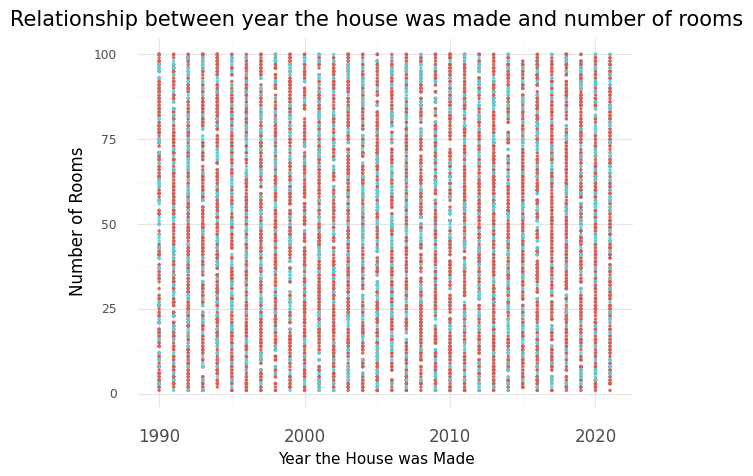

<ggplot: (332342884)>

In [50]:
# made vs numberOfRooms scatterplot with cluster coloring
(ggplot(paris, aes(x = "made", y = "numberOfRooms", color = "factor(cluster2)")) +
 geom_point(size = 0.4, alpha = 0.9) + theme_minimal() +
 labs(title = "Relationship between year the house was made and number of rooms",
     x = "Year the House was Made", y = "Number of Rooms") +
 theme(axis_title_y = element_text(size = 12),
       axis_text_x = element_text(size = 12),
       plot_title = element_text(size = 15), 
       legend_position = "none"))

- If we look at the scatterplots denoting the relationships between the variables `price`, `made`, and `numberOfRooms`, we can see that there seems to be a extremely weak relationship between these three variables, which is shown in the randomness in the points. Because there are no visible clusters, this makes it more difficult in choosing a clustering algorithm. We cannot use KMeans Clustering because it relies on the assumption of spherical clusters and if we look at our scatterplots, we have no spherical clusters. We cannot use Gaussian Mixture Models because it relies on the assumption of elliptical clusters. Moreover, DBSCAN would not work with this dataset because DBSCAN works poorly for overlapping/touching clusters, and in our data set all the points look like they are touching. Thus, we are left with one option: **Hierarchical Agglomerative Clustering** (HAC). 

- In hierarchical agglomerative clustering we take clusters and merge them together successively; these clusters first start as end points and are grouped together into clusters until we reach one giant cluster at the end, whcih forms a hierarchy. The benefits of using HAC are that it is flexible in the number of clusters you choose and it models the relationship between clusters through a hierarchy. Moreover, we are flexible in choosing the linkage criteria, but most importantly HAC does not make assumptions about the data. The downside though are that it is very slow (run time of $O(n^3)$ and you cannot unmerge clusters. For our clustering model, it took us about 281 seconds (4 minutes 41 seconds) to run HAC and make a dendrogram.

- Since we are using HAC, we need to discuss how we choose the hyperparameters. To decide on the hyperparameter of distance metric, which is how we decide how close two points are, we used Euclidean distance. We used this distance metric because it is best to use this with continuous data, which describes all the variables that we are using in our clustering algorithm. To decide on the hyperparameter of linkage criteria, which is how we decide how close two clusters are, we used Ward's method/criteria. Ward's method sees that if we merge two clusters, then how much are we increasing the average deviation of the mean to each data point. We believe that this would be the most favorable linkage criteria since it would be difficult to form clusters based on the data.

- If we look at the dendrogram above, there is a lot of density (short connections) at the bottom graph, however, we can tell that the data is not separate and coehisive since there are still merges in the middle of the graph. This is what we expected considering the shape and form of the relationships of the variables.

- If we were to give these clusters labels, the red cluster would be the a cheap or average type of house, whereas the blue cluster would be the expensive homes. Possibly the homes in the blue cluster would be advertised to people with a very high income and the red cluster is a home that can be advertised to the average person.